# AID843: STDA-I — Assignment 1
## Spatiotemporal Analysis of Football Shot Events (FIFA Dataset)
**Tasks:** Preprocessing → Spatial Autocorrelation (Global + Local) → Spatial Heterogeneity & Stationarity → Spatial Regression Models

## Cell 1: Library Imports & Verification

In [1]:
import pandas
import geopandas
import libpysal
import esda
import spreg

print("Core libraries OK")

try:
    import mgwr
    print("mgwr OK")
except ImportError:
    print("mgwr not found — install with: pip install mgwr")


Core libraries OK
mgwr OK


## Cell 2: Full Imports

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from shapely.geometry import Point

# Spatial weights
from libpysal.weights import KNN, DistanceBand

# Autocorrelation
from splot.esda import moran_scatterplot
from esda.moran import Moran, Moran_Local
from esda.geary import Geary
from esda.getisord import G, G_Local

# Regression
from spreg import OLS, GM_Lag, GM_Error

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Viz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

print("All imports successful.")


All imports successful.


---
## Task 1: Data Preprocessing
- Load event data for 4 leagues
- Filter to Shot events
- Create a 10x10 spatial grid over the pitch
- Aggregate shot counts per grid cell
- Build GeoDataFrame with spatial geometry

In [3]:
# ==============================
# Exploratory: Inspect raw data
# ==============================

df_sample = pd.read_csv('events_Spain.csv')

print("Shape:", df_sample.shape)
print("\nColumns:", df_sample.columns.tolist())
print("\nEvent types:")
print(df_sample['eventName'].value_counts())
print("\nSample rows:")
df_sample[df_sample['eventName'] == 'Shot'][['pos_orig_x', 'pos_orig_y', 'eventName']].head(5)


Shape: (628550, 17)

Columns: ['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId', 'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id', 'tagsList', 'pos_orig_y', 'pos_orig_x', 'pos_dest_y', 'pos_dest_x']

Event types:
eventName
Pass                       318680
Duel                       172020
Others on the ball          48313
Free Kick                   38062
Interruption                25991
Foul                        10961
Shot                         7977
Save attempt                 3409
Offside                      1881
Goalkeeper leaving line      1256
Name: count, dtype: int64

Sample rows:


,pos_orig_x,pos_orig_y,eventName
20,93,34,Shot
22,80,59,Shot
107,88,57,Shot
111,87,66,Shot
228,75,40,Shot


In [4]:
# ==============================
# TASK 1 + 2 + 3 + 4: Core Analysis Function
# Runs all analyses for a single league
# ==============================

def run_league_analysis(file_name, league_name, grid_size=10, k_neighbors=4):
    
    print(f"\n{'='*50}")
    print(f"  {league_name}")
    print(f"{'='*50}")
    
    # -------------------------------------------
    # TASK 1: PREPROCESSING
    # -------------------------------------------
    df = pd.read_csv(file_name)
    df = df[df['eventName'] == 'Shot']
    df = df[['pos_orig_x', 'pos_orig_y']].dropna()
    
    # Clip to valid pitch range [0, 100]
    df = df[(df['pos_orig_x'] >= 0) & (df['pos_orig_x'] <= 100)]
    df = df[(df['pos_orig_y'] >= 0) & (df['pos_orig_y'] <= 100)]
    
    print(f"Total shots after cleaning: {len(df)}")
    
    # Create spatial grid bins
    df['x_bin'] = (df['pos_orig_x'] // grid_size).astype(int)
    df['y_bin'] = (df['pos_orig_y'] // grid_size).astype(int)
    
    # Aggregate shot counts per grid cell
    density = df.groupby(['x_bin', 'y_bin']).size().reset_index(name='shot_count')
    
    # Compute centroids for each grid cell
    density['x_coord'] = density['x_bin'] * grid_size + grid_size / 2
    density['y_coord'] = density['y_bin'] * grid_size + grid_size / 2
    
    # Build GeoDataFrame
    gdf = gpd.GeoDataFrame(
        density,
        geometry=gpd.points_from_xy(density['x_coord'], density['y_coord']),
        crs='EPSG:4326'
    )
    
    print(f"Grid cells with shots: {len(gdf)}")
    
    # -------------------------------------------
    # SPATIAL WEIGHTS
    # KNN (primary) + Distance Band (secondary)
    # -------------------------------------------
    w_knn = KNN.from_dataframe(gdf, k=k_neighbors)
    w_knn.transform = 'R'
    
    # Distance-band weights (threshold = 15 pitch units)
    try:
        w_dist = DistanceBand.from_dataframe(gdf, threshold=15, binary=True)
        w_dist.transform = 'R'
        has_dist_weights = True
    except Exception as e:
        print(f"  Distance-band weights failed: {e}")
        has_dist_weights = False
    
    y = gdf['shot_count'].astype(float).values
    
    # -------------------------------------------
    # TASK 2A: GLOBAL SPATIAL AUTOCORRELATION
    # Method 1: Global Moran's I
    # Method 2: Geary's C
    # Method 3: Getis-Ord G
    # -------------------------------------------
    print("\n Global Spatial Autocorrelation")
    
    # Moran's I (KNN weights)
    moran = Moran(y, w_knn)
    print(f"  Moran's I (KNN):  {moran.I:.4f}  (p={moran.p_sim:.4f})")
    
    # Geary's C (KNN weights)  — C < 1 = positive autocorrelation
    geary = Geary(y, w_knn)
    print(f"  Geary's C (KNN):  {geary.C:.4f}  (p={geary.p_sim:.4f})")
    
    # Getis-Ord Global G (KNN weights) — measures clustering of high values
    getis_g = G(y, w_knn)
    print(f"  Getis-Ord G:      {getis_g.G:.6f}  (p={getis_g.p_sim:.4f})")
    
    # Moran's I with Distance-Band weights (for comparison)
    moran_dist_I = None
    moran_dist_p = None
    if has_dist_weights:
        try:
            moran_dist = Moran(y, w_dist)
            moran_dist_I = moran_dist.I
            moran_dist_p = moran_dist.p_sim
            print(f"  Moran's I (Dist): {moran_dist_I:.4f}  (p={moran_dist_p:.4f})")
        except Exception as e:
            print(f"  Moran (Dist) failed: {e}")
    
    # -------------------------------------------
    # TASK 2B: LOCAL SPATIAL AUTOCORRELATION
    # Method 1: Local Moran's I (LISA)
    # Method 2: Local Getis-Ord G* (Hotspot)
    # -------------------------------------------
    print("\nLocal Spatial Autocorrelation")
    
    # Local Moran's I (LISA)
    lisa = Moran_Local(y, w_knn,n_jobs=1)
    sig_lisa = lisa.p_sim < 0.05
    
    gdf['lisa_cluster'] = 0
    gdf.loc[sig_lisa & (lisa.q == 1), 'lisa_cluster'] = 1  # High-High
    gdf.loc[sig_lisa & (lisa.q == 2), 'lisa_cluster'] = 2  # Low-High
    gdf.loc[sig_lisa & (lisa.q == 3), 'lisa_cluster'] = 3  # Low-Low
    gdf.loc[sig_lisa & (lisa.q == 4), 'lisa_cluster'] = 4  # High-Low
    
    lisa_counts = gdf['lisa_cluster'].value_counts().sort_index()
    cluster_labels = {0: 'Not Sig', 1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
    print("  LISA Clusters:")
    for k, v in lisa_counts.items():
        print(f"    {cluster_labels.get(k, k)}: {v} cells")
    
    # Local G* Hotspot Analysis
    g_local = G_Local(y, w_knn, transform='R', star=True,n_jobs=1)
    gdf['hotspot'] = 0
    sig_g = g_local.p_sim < 0.05
    gdf.loc[sig_g & (g_local.Zs > 0), 'hotspot'] = 1   # Hot spot
    gdf.loc[sig_g & (g_local.Zs < 0), 'hotspot'] = -1  # Cold spot
    
    hotspot_counts = gdf['hotspot'].value_counts().sort_index()
    hs_labels = {-1: 'Cold Spot', 0: 'Not Sig', 1: 'Hot Spot'}
    print("  G* Hotspots:")
    for k, v in hotspot_counts.items():
        print(f"    {hs_labels.get(k, k)}: {v} cells")
    
    # -------------------------------------------
    # TASK 3: SPATIAL HETEROGENEITY & STATIONARITY
    # Descriptive statistics + CV + Zone comparison
    # -------------------------------------------
    print("\n Spatial Heterogeneity")
    
    variance = np.var(y)
    mean_density = np.mean(y)
    cv = np.std(y) / mean_density  # Coefficient of Variation
    
    print(f"  Mean shot density:  {mean_density:.2f}")
    print(f"  Variance:           {variance:.2f}")
    print(f"  Coeff of Variation: {cv:.3f}  (higher = more heterogeneous)")
    
    # Spatial stationarity: compare mean density across 3 pitch zones
    # Zone A: Defensive (x < 33), Zone B: Midfield (33–66), Zone C: Attacking (x > 66)
    zone_a = gdf[gdf['x_coord'] < 33]['shot_count']
    zone_b = gdf[(gdf['x_coord'] >= 33) & (gdf['x_coord'] <= 66)]['shot_count']
    zone_c = gdf[gdf['x_coord'] > 66]['shot_count']
    
    print(f"  Zone A (Defensive) mean: {zone_a.mean():.2f}  n={len(zone_a)}")
    print(f"  Zone B (Midfield)  mean: {zone_b.mean():.2f}  n={len(zone_b)}")
    print(f"  Zone C (Attacking) mean: {zone_c.mean():.2f}  n={len(zone_c)}")
    
    # Levene's test for heterogeneity of variance across zones
    from scipy.stats import levene, f_oneway
    zones_data = [z.values for z in [zone_a, zone_b, zone_c] if len(z) >= 2]
    if len(zones_data) == 3:
        lev_stat, lev_p = levene(*zones_data)
        anova_stat, anova_p = f_oneway(*zones_data)
        print(f"  Levene's test: stat={lev_stat:.4f}, p={lev_p:.4f}")
        print(f"  ANOVA (zone means): stat={anova_stat:.4f}, p={anova_p:.4f}")
        print(f"  => {'Significant spatial non-stationarity' if lev_p < 0.05 else 'No significant variance heterogeneity'}")
    else:
        lev_stat, lev_p, anova_stat, anova_p = None, None, None, None
    
    # -------------------------------------------
    # TASK 4: SPATIAL REGRESSION MODELS
    # Model 1: OLS (baseline)
    # Model 2: Spatial Lag (GM_Lag)
    # Model 3: Spatial Error (GM_Error)
    # Validation: holdout test set
    # -------------------------------------------
    print("\n--- Spatial Regression Models ---")
    
    X_feats = np.column_stack((gdf['x_coord'].values, gdf['y_coord'].values))
    y_vals = y.astype(float).reshape(-1, 1)

    
    # Train/Test Split (80/20 holdout)
    idx = np.arange(len(gdf))
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=42)
    
    X_train = X_feats[idx_train]
    X_test  = X_feats[idx_test]
    y_train = y_vals[idx_train]
    y_test  = y_vals[idx_test].flatten()
    
    gdf_train = gdf.iloc[idx_train].copy().reset_index(drop=True)
    
    # Spatial weights on training set only
    w_train = KNN.from_dataframe(gdf_train, k=k_neighbors)
    w_train.transform = 'R'
    
    # --- Model 1: OLS ---
    ols = OLS(y_train, X_train)
    ols_pred_train = ols.predy.flatten()
    
    # OLS predict on test (manual: X_test @ betas + intercept)
    X_test_aug = np.hstack([np.ones((len(X_test), 1)), X_test])
    ols_pred_test = X_test_aug @ ols.betas.flatten()
    ols_mae  = mean_absolute_error(y_test, ols_pred_test)
    ols_r2   = r2_score(y_test, ols_pred_test)
    
    print(f"  OLS      — MAE: {ols_mae:.4f}  R2: {ols_r2:.4f}")
    
    # --- Model 2: Spatial Lag (GM_Lag) ---
    lag_model = GM_Lag(y_train, X_train, w=w_train)
    lag_pred_test = X_test_aug @ lag_model.betas[:3].flatten()  # use non-spatial betas for test prediction
    lag_mae  = mean_absolute_error(y_test, lag_pred_test)
    lag_r2   = r2_score(y_test, lag_pred_test)
    
    print(f"  Lag      — MAE: {lag_mae:.4f}  R2: {lag_r2:.4f}  Pseudo-R2: {lag_model.pr2:.4f}")
    
    # Residual autocorrelation check (Lag model on train)
    lag_res = y_train.flatten() - lag_model.predy.flatten()
    res_moran_lag = Moran(lag_res, w_train)
    print(f"  Lag Residual Moran's I: {res_moran_lag.I:.4f}  (p={res_moran_lag.p_sim:.4f})")
    
    # --- Model 3: Spatial Error (GM_Error) ---
    err_model = GM_Error(y_train, X_train, w=w_train)
    err_pred_test = X_test_aug @ err_model.betas[:3].flatten()
    err_mae  = mean_absolute_error(y_test, err_pred_test)
    err_r2   = r2_score(y_test, err_pred_test)
    
    print(f"  Error    — MAE: {err_mae:.4f}  R2: {err_r2:.4f}")
    
    # Residual autocorrelation check (Error model on train)
    err_res = y_train.flatten() - err_model.predy.flatten()
    res_moran_err = Moran(err_res, w_train)
    print(f"  Error Residual Moran's I: {res_moran_err.I:.4f}  (p={res_moran_err.p_sim:.4f})")
    
    return {
        "League": league_name,
        # Autocorrelation
        "Moran_I": moran.I,
        "Moran_p": moran.p_sim,
        "Geary_C": geary.C,
        "Geary_p": geary.p_sim,
        "Getis_G": getis_g.G,
        "Getis_G_p": getis_g.p_sim,
        "Moran_Dist_I": moran_dist_I,
        "Moran_Dist_p": moran_dist_p,
        # Heterogeneity
        "Mean_Density": mean_density,
        "Variance": variance,
        "CV": cv,
        "Levene_stat": lev_stat,
        "Levene_p": lev_p,
        "ANOVA_p": anova_p,
        # Regression
        "OLS_MAE": ols_mae, "OLS_R2": ols_r2,
        "Lag_MAE": lag_mae, "Lag_R2": lag_r2, "Lag_PR2": lag_model.pr2,
        "Lag_ResidMoran_I": res_moran_lag.I, "Lag_ResidMoran_p": res_moran_lag.p_sim,
        "Err_MAE": err_mae, "Err_R2": err_r2,
        "Err_ResidMoran_I": res_moran_err.I, "Err_ResidMoran_p": res_moran_err.p_sim,
        # Spatial data
        "gdf": gdf
    }


## Run Analysis for All Leagues

In [5]:
LEAGUE_FILES = {
    "Spain":   "events_Spain.csv",
    "Italy":   "events_Italy.csv",
    "Germany": "events_Germany.csv",
    "France":  "events_France.csv"
}

results = []
league_maps = {}

for league, file in LEAGUE_FILES.items():
    res = run_league_analysis(file, league)
    league_maps[league] = res["gdf"]
    results.append({k: v for k, v in res.items() if k != "gdf"})

results_df = pd.DataFrame(results)
print("\nSummary Table ")
display_cols = ['League', 'Moran_I', 'Moran_p', 'Geary_C', 'Geary_p',
                'CV', 'OLS_MAE', 'Lag_MAE', 'Err_MAE', 'Lag_PR2']
results_df[display_cols].round(4)



  Spain
Total shots after cleaning: 7977
Grid cells with shots: 121

 Global Spatial Autocorrelation
  Moran's I (KNN):  0.3246  (p=0.0010)
  Geary's C (KNN):  0.5629  (p=0.0010)
  Getis-Ord G:      0.037838  (p=0.0010)
  Moran's I (Dist): 0.2854  (p=0.0010)

Local Spatial Autocorrelation
  LISA Clusters:
    Not Sig: 100 cells
    HH: 2 cells
    LL: 18 cells
    HL: 1 cells
  G* Hotspots:
    Cold Spot: 20 cells
    Not Sig: 99 cells
    Hot Spot: 2 cells

 Spatial Heterogeneity
  Mean shot density:  65.93
  Variance:           1752.18
  Coeff of Variation: 0.635  (higher = more heterogeneous)
  Zone A (Defensive) mean: 60.00  n=33
  Zone B (Midfield)  mean: 87.84  n=44
  Zone C (Attacking) mean: 48.45  n=44
  Levene's test: stat=0.7943, p=0.4543
  ANOVA (zone means): stat=11.9549, p=0.0000
  => No significant variance heterogeneity

--- Spatial Regression Models ---
  OLS      — MAE: 31.3055  R2: 0.1140
  Lag      — MAE: 53.7221  R2: -0.4751  Pseudo-R2: 0.1775
  Lag Residual Moran'

,League,Moran_I,Moran_p,Geary_C,Geary_p,CV,OLS_MAE,Lag_MAE,Err_MAE,Lag_PR2
0,Spain,0.3246,0.001,0.5629,0.001,0.6349,31.3055,53.7221,31.9912,0.1775
1,Italy,0.3909,0.001,0.5191,0.001,0.6025,34.1640,45.0200,35.2900,0.1438
2,Germany,0.1948,0.002,0.6563,0.001,0.7175,29.9532,132.6786,30.3243,0.1800
3,France,0.1250,0.025,0.7155,0.001,0.7491,38.4829,135.2651,38.6304,0.0830


---
## Visualizations
### Figure 1: Shot Density KDE Heatmaps (All Leagues)

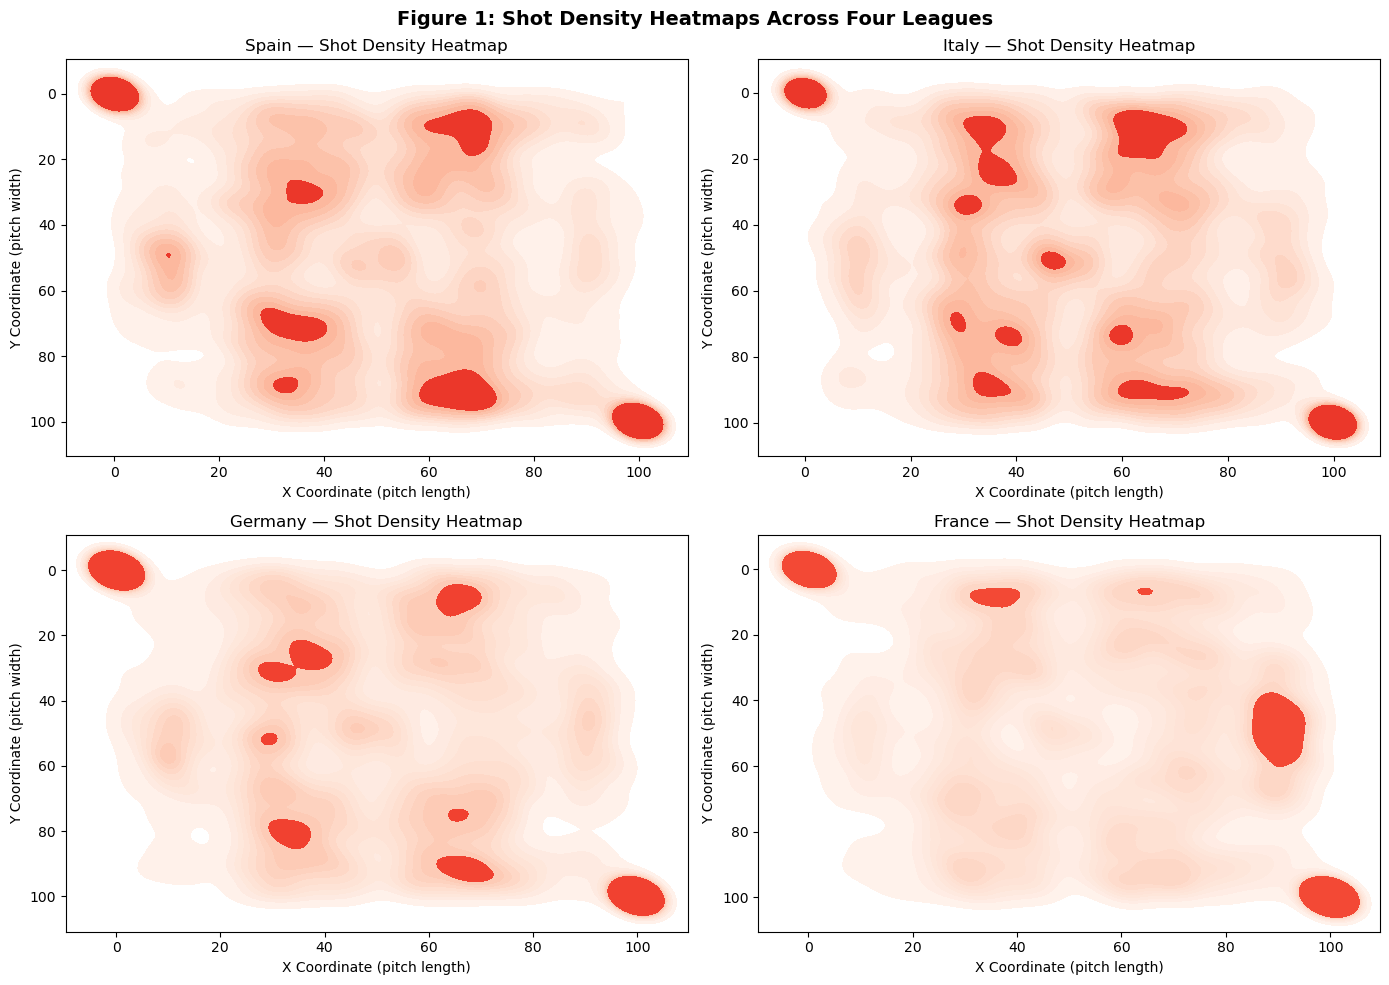

Saved: fig1_shot_heatmaps.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (league, file) in enumerate(LEAGUE_FILES.items()):
    df = pd.read_csv(file)
    df = df[df['eventName'] == 'Shot']
    df = df[(df['pos_orig_x'].between(0, 100)) & (df['pos_orig_y'].between(0, 100))]
    
    ax = axes[i]
    sns.kdeplot(
        x=df['pos_orig_x'], y=df['pos_orig_y'],
        fill=True, cmap='Reds', bw_adjust=0.5, ax=ax
    )
    ax.set_title(f"{league} — Shot Density Heatmap", fontsize=12)
    ax.set_xlabel("X Coordinate (pitch length)")
    ax.set_ylabel("Y Coordinate (pitch width)")
    ax.invert_yaxis()

plt.suptitle("Figure 1: Shot Density Heatmaps Across Four Leagues", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig1_shot_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig1_shot_heatmaps.png")


### Figure 2: Grid Shot Count Maps

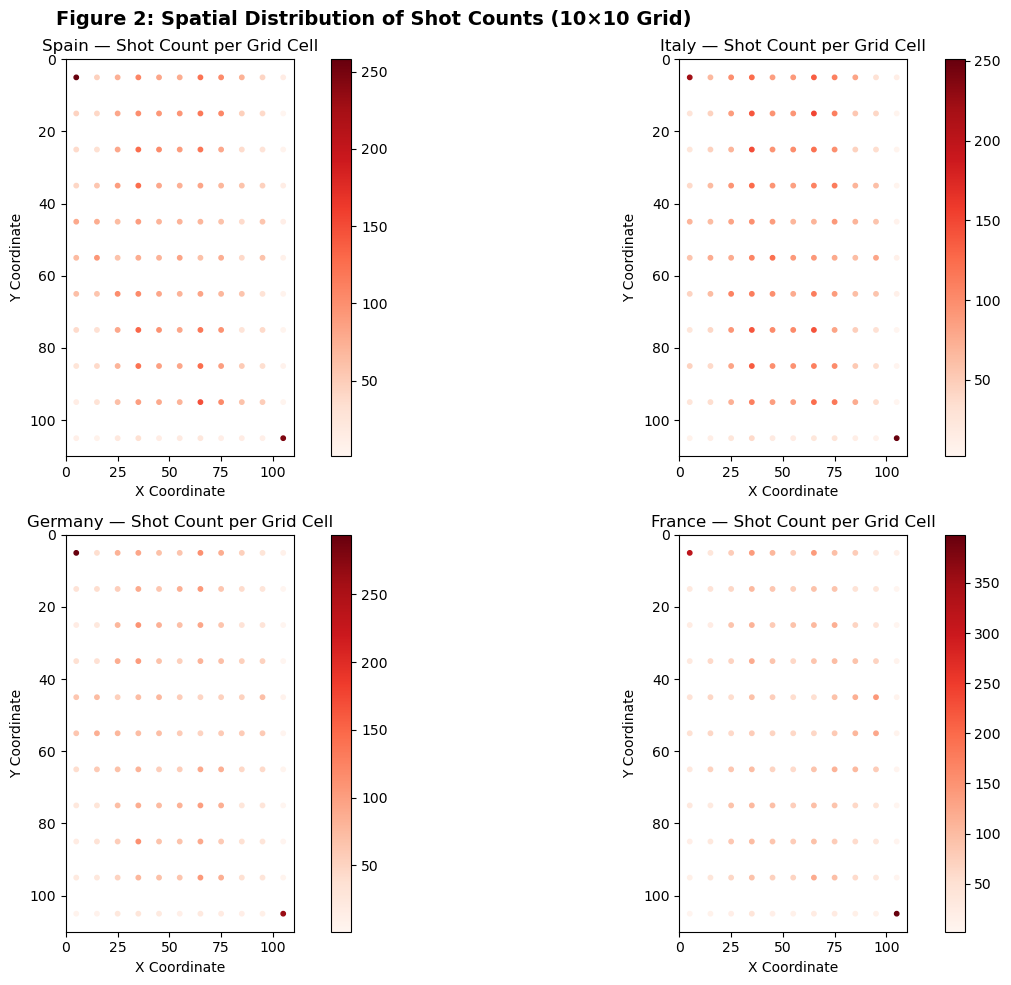

Saved: fig2_grid_density.png


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, league in enumerate(league_maps):
    gdf = league_maps[league]
    ax = axes[i]
    gdf.plot(column='shot_count', cmap='Reds', legend=True, markersize=10, ax=ax)
    ax.set_title(f"{league} — Shot Count per Grid Cell", fontsize=12)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.invert_yaxis()

plt.suptitle("Figure 2: Spatial Distribution of Shot Counts (10×10 Grid)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig2_grid_density.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig2_grid_density.png")


### Figure 3: LISA Cluster Maps (Local Moran's I)

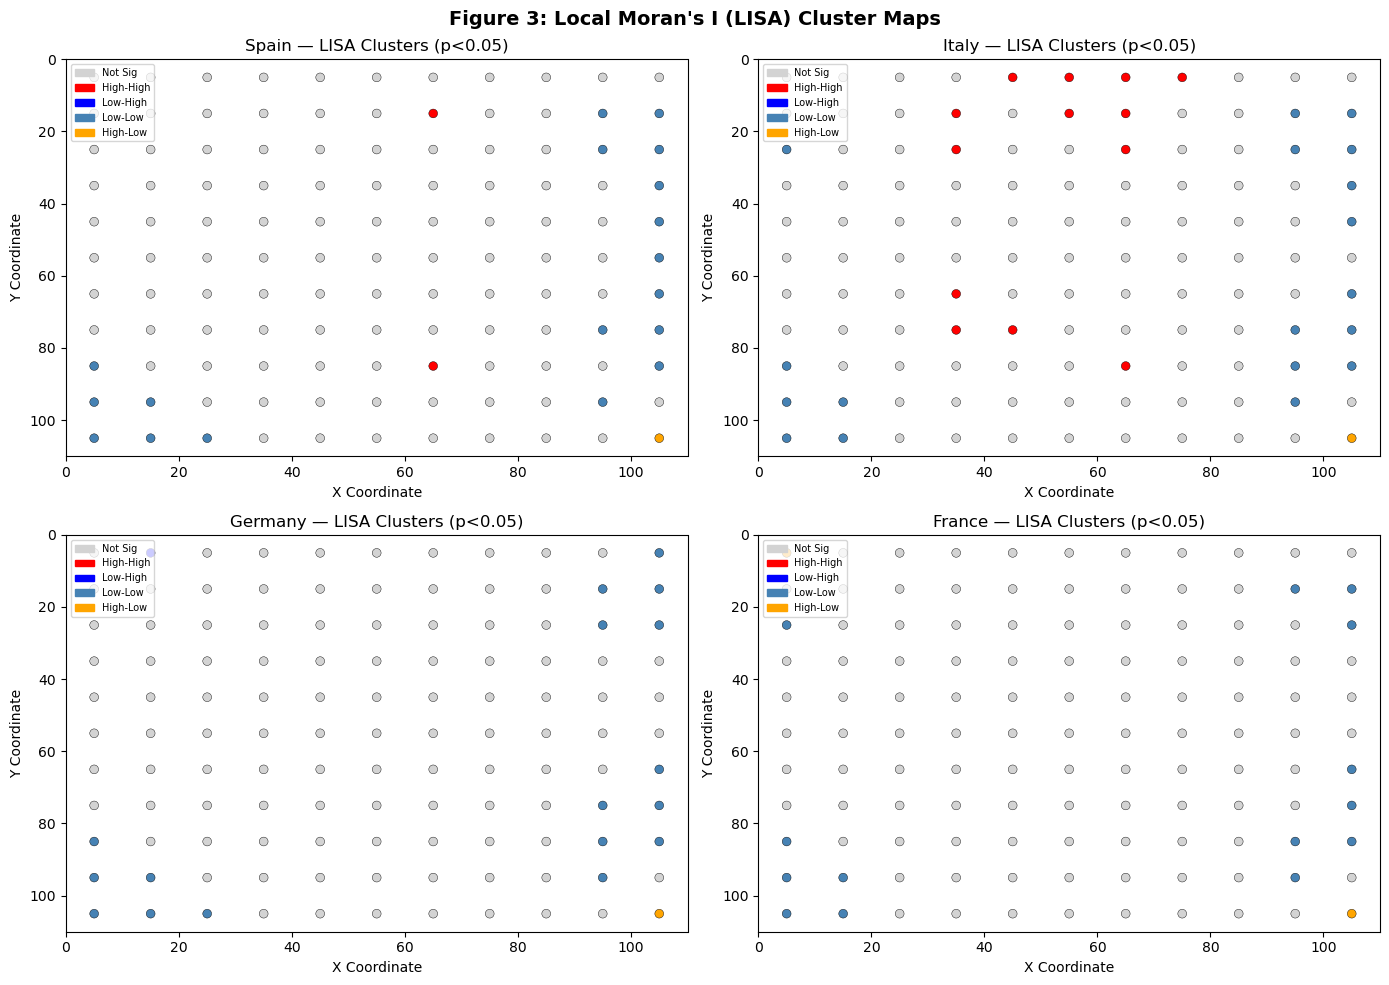

Saved: fig3_lisa_clusters.png


In [8]:
cluster_colors = {0: 'lightgrey', 1: 'red', 2: 'blue', 3: 'steelblue', 4: 'orange'}
cluster_labels_map = {0: 'Not Sig', 1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, league in enumerate(league_maps):
    gdf = league_maps[league]
    ax = axes[i]
    
    colors = gdf['lisa_cluster'].map(cluster_colors).fillna('lightgrey')
    ax.scatter(gdf['x_coord'], gdf['y_coord'], c=colors, s=40, edgecolors='black', linewidths=0.3)
    
    patches = [mpatches.Patch(color=c, label=cluster_labels_map[k]) for k, c in cluster_colors.items()]
    ax.legend(handles=patches, loc='upper left', fontsize=7)
    ax.set_title(f"{league} — LISA Clusters (p<0.05)", fontsize=12)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.invert_yaxis()

plt.suptitle("Figure 3: Local Moran's I (LISA) Cluster Maps", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig3_lisa_clusters.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig3_lisa_clusters.png")


### Figure 4: G* Hotspot Maps

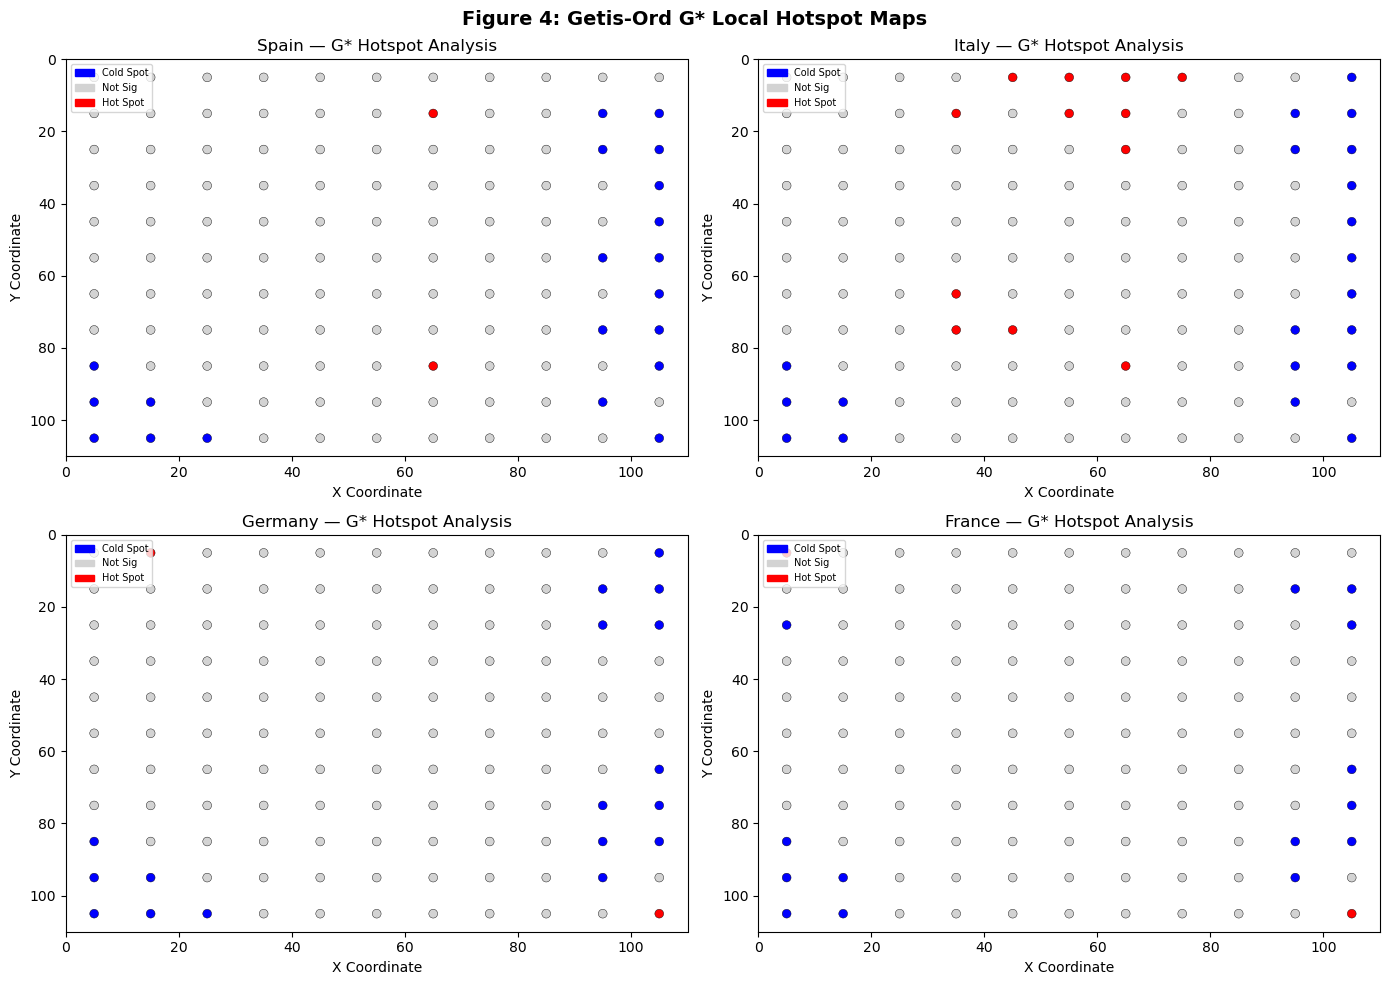

Saved: fig4_hotspot_maps.png


In [9]:
hotspot_colors = {-1: 'blue', 0: 'lightgrey', 1: 'red'}
hotspot_labels = {-1: 'Cold Spot', 0: 'Not Sig', 1: 'Hot Spot'}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, league in enumerate(league_maps):
    gdf = league_maps[league]
    ax = axes[i]
    
    colors = gdf['hotspot'].map(hotspot_colors).fillna('lightgrey')
    ax.scatter(gdf['x_coord'], gdf['y_coord'], c=colors, s=40, edgecolors='black', linewidths=0.3)
    
    patches = [mpatches.Patch(color=c, label=hotspot_labels[k]) for k, c in hotspot_colors.items()]
    ax.legend(handles=patches, loc='upper left', fontsize=7)
    ax.set_title(f"{league} — G* Hotspot Analysis", fontsize=12)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.invert_yaxis()

plt.suptitle("Figure 4: Getis-Ord G* Local Hotspot Maps", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig4_hotspot_maps.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig4_hotspot_maps.png")


### Figure 5: Cross-League Autocorrelation Comparison

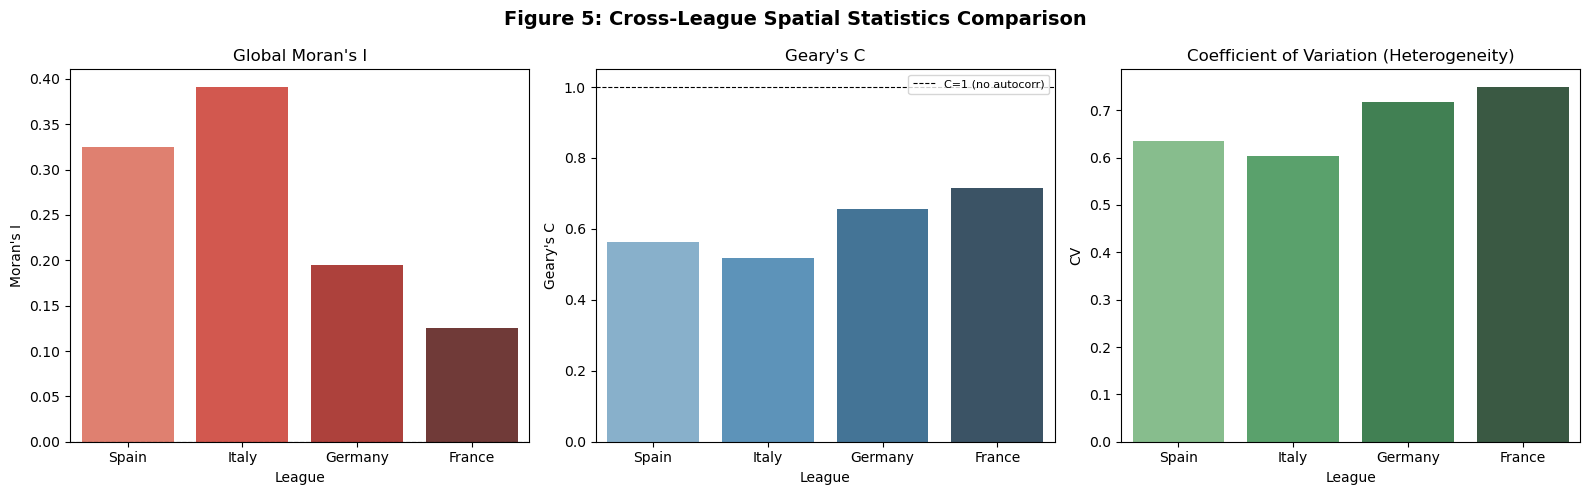

Saved: fig5_global_stats.png


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Moran's I
sns.barplot(data=results_df, x='League', y='Moran_I', ax=axes[0], palette='Reds_d')
axes[0].set_title("Global Moran's I", fontsize=12)
axes[0].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_ylabel("Moran's I")

# Geary's C
sns.barplot(data=results_df, x='League', y='Geary_C', ax=axes[1], palette='Blues_d')
axes[1].set_title("Geary's C", fontsize=12)
axes[1].axhline(1, color='black', linestyle='--', linewidth=0.8, label='C=1 (no autocorr)')
axes[1].legend(fontsize=8)
axes[1].set_ylabel("Geary's C")

# CV (Heterogeneity)
sns.barplot(data=results_df, x='League', y='CV', ax=axes[2], palette='Greens_d')
axes[2].set_title("Coefficient of Variation (Heterogeneity)", fontsize=12)
axes[2].set_ylabel("CV")

plt.suptitle("Figure 5: Cross-League Spatial Statistics Comparison", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig5_global_stats.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig5_global_stats.png")


### Figure 6: Regression Model Comparison (MAE)

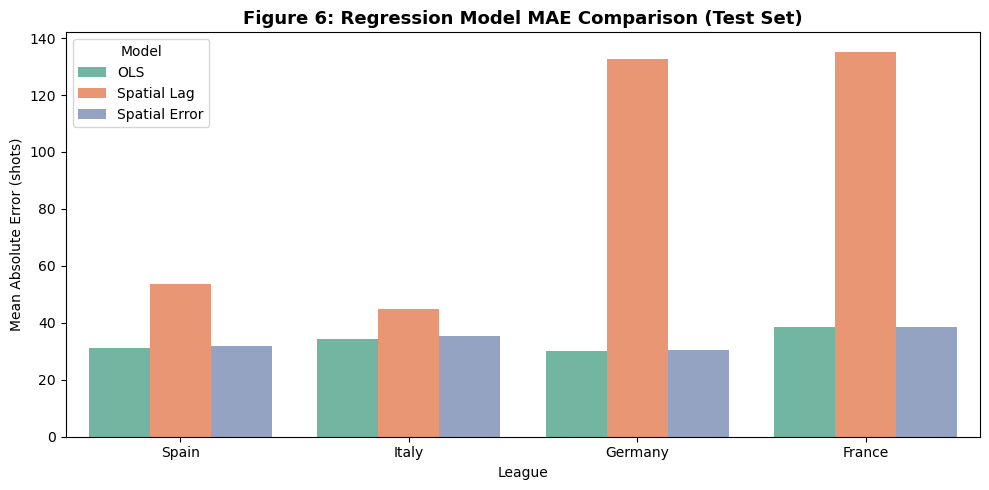

Saved: fig6_model_comparison.png


In [11]:
# Reshape for grouped bar chart
model_comparison = results_df[['League', 'OLS_MAE', 'Lag_MAE', 'Err_MAE']].copy()
model_melt = model_comparison.melt(id_vars='League', var_name='Model', value_name='MAE')
model_melt['Model'] = model_melt['Model'].map({'OLS_MAE': 'OLS', 'Lag_MAE': 'Spatial Lag', 'Err_MAE': 'Spatial Error'})

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=model_melt, x='League', y='MAE', hue='Model', ax=ax, palette='Set2')
ax.set_title("Figure 6: Regression Model MAE Comparison (Test Set)", fontsize=13, fontweight='bold')
ax.set_ylabel("Mean Absolute Error (shots)")
ax.set_xlabel("League")
ax.legend(title='Model')

plt.tight_layout()
plt.savefig('fig6_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig6_model_comparison.png")


### Figure 7: Moran Scatterplot (Spain)

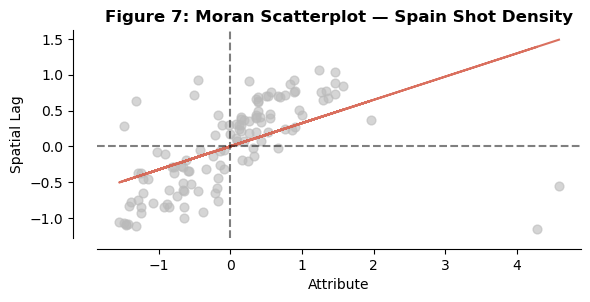

Saved: fig7_moran_scatter.png


In [12]:


spain_gdf = league_maps["Spain"]
y_spain = spain_gdf['shot_count'].values
w_spain = KNN.from_dataframe(spain_gdf, k=4)
w_spain.transform = 'R'

moran_spain = Moran(y_spain, w_spain)

fig, ax = plt.subplots(figsize=(6, 5))
moran_scatterplot(moran_spain, ax=ax)
ax.set_title("Figure 7: Moran Scatterplot — Spain Shot Density", fontweight='bold')
plt.tight_layout()
plt.savefig('fig7_moran_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: fig7_moran_scatter.png")


---
## Task 3 (Extended): Geographically Weighted Regression (GWR)
GWR captures spatial non-stationarity by fitting local regression models at each location.
Applied to Spain as a case study.

Selecting GWR bandwidth (this may take ~1-2 min)...
Optimal bandwidth: 51.0
GWR R²:          0.4140
GWR Adjusted R²: 0.3594


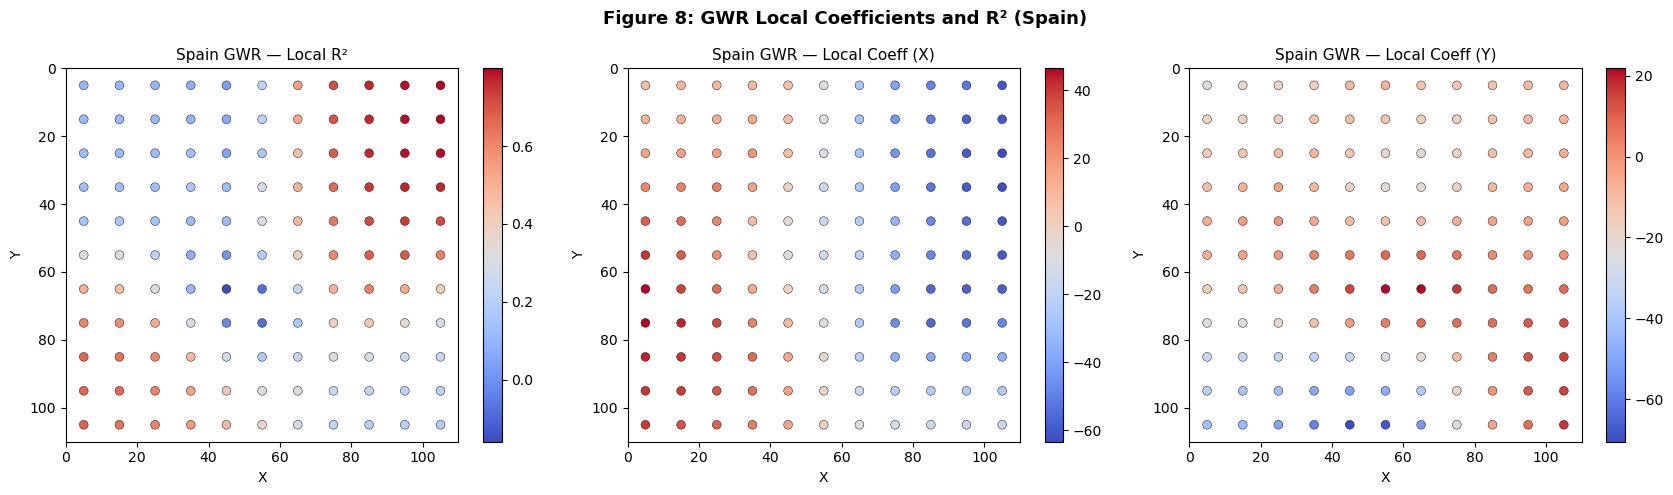

Saved: fig8_gwr_coefficients.png


In [13]:
# ==============================
# GWR Analysis (Spain — case study)
# ==============================

try:
    from mgwr.gwr import GWR
    from mgwr.sel_bw import Sel_BW

    spain_gdf = league_maps["Spain"].copy()

    # Coordinates array
    coords = np.array(list(zip(spain_gdf['x_coord'], spain_gdf['y_coord'])))

    # Dependent variable
    y_gwr = spain_gdf['shot_count'].values.reshape(-1, 1)

    # Standardize predictors
    X_raw = np.column_stack((spain_gdf['x_coord'].values, spain_gdf['y_coord'].values))
    X_gwr = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

    # Select optimal bandwidth
    print("Selecting GWR bandwidth (this may take ~1-2 min)...")
    selector = Sel_BW(coords, y_gwr, X_gwr)
    bw = selector.search(criterion='AICc')
    print(f"Optimal bandwidth: {bw}")

    # Fit GWR
    gwr_model = GWR(coords, y_gwr, X_gwr, bw)
    gwr_results = gwr_model.fit()

    print(f"GWR R²:          {gwr_results.R2:.4f}")
    print(f"GWR Adjusted R²: {gwr_results.adj_R2:.4f}")

    # Store local coefficients
    spain_gdf['gwr_beta0'] = gwr_results.params[:, 0]  # intercept
    spain_gdf['gwr_beta_x'] = gwr_results.params[:, 1]
    spain_gdf['gwr_beta_y'] = gwr_results.params[:, 2]
    spain_gdf['gwr_localR2'] = gwr_results.localR2

    # Plot local R² and coefficients
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    for ax, col, title in zip(axes,
        ['gwr_localR2', 'gwr_beta_x', 'gwr_beta_y'],
        ['Local R²', 'Local Coeff (X)', 'Local Coeff (Y)']):
        sc = ax.scatter(spain_gdf['x_coord'], spain_gdf['y_coord'],c=spain_gdf[col], cmap='coolwarm', s=40, edgecolors='k', linewidths=0.3)
        plt.colorbar(sc, ax=ax)
        ax.set_title(f"Spain GWR — {title}", fontsize=11)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.invert_yaxis()

    plt.suptitle("Figure 8: GWR Local Coefficients and R² (Spain)", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig('fig8_gwr_coefficients.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: fig8_gwr_coefficients.png")

except ImportError:
    print("mgwr not installed. Skipping GWR. Install with: pip install mgwr")
except Exception as e:
    print(f"GWR failed: {e}")


---
## Final Summary Table

In [14]:
print("\nFULL RESULTS SUMMARY")
print("\nSpatial Autocorrelation")
ac_cols = ['League', 'Moran_I', 'Moran_p', 'Geary_C', 'Geary_p', 'Getis_G', 'Getis_G_p']
print(results_df[ac_cols].to_string(index=False))

print("\nSpatial Heterogeneity")
het_cols = ['League', 'Mean_Density', 'Variance', 'CV', 'Levene_p', 'ANOVA_p']
print(results_df[het_cols].to_string(index=False))

print("\nRegression Model Performance (Test Set)")
reg_cols = ['League', 'OLS_MAE', 'OLS_R2', 'Lag_MAE', 'Lag_R2', 'Lag_PR2','Err_MAE', 'Err_R2', 'Lag_ResidMoran_I', 'Lag_ResidMoran_p']
print(results_df[reg_cols].to_string(index=False))
results_df



FULL RESULTS SUMMARY

Spatial Autocorrelation
 League  Moran_I  Moran_p  Geary_C  Geary_p  Getis_G  Getis_G_p
  Spain 0.324566    0.001 0.562939    0.001 0.037838      0.001
  Italy 0.390940    0.001 0.519129    0.001 0.038480      0.001
Germany 0.194840    0.002 0.656310    0.001 0.036574      0.008
 France 0.124965    0.025 0.715463    0.001 0.035617      0.041

Spatial Heterogeneity
 League  Mean_Density    Variance       CV  Levene_p  ANOVA_p
  Spain     65.925620 1752.184550 0.634944  0.454292 0.000019
  Italy     72.776860 1922.536985 0.602482  0.125351 0.000001
Germany     56.991736 1672.123899 0.717501  0.312744 0.001905
 France     68.809917 2656.649819 0.749059  0.029161 0.080834

Regression Model Performance (Test Set)
 League   OLS_MAE    OLS_R2    Lag_MAE    Lag_R2  Lag_PR2   Err_MAE    Err_R2  Lag_ResidMoran_I  Lag_ResidMoran_p
  Spain 31.305506  0.113973  53.722082 -0.475138 0.177451 31.991208  0.085799          0.625518             0.001
  Italy 34.164038  0.113171  45

,League,Moran_I,Moran_p,Geary_C,Geary_p,Getis_G,Getis_G_p,Moran_Dist_I,Moran_Dist_p,Mean_Density,...,OLS_R2,Lag_MAE,Lag_R2,Lag_PR2,Lag_ResidMoran_I,Lag_ResidMoran_p,Err_MAE,Err_R2,Err_ResidMoran_I,Err_ResidMoran_p
0,Spain,0.324566,0.001,0.562939,0.001,0.037838,0.001,0.285375,0.001,65.925620,...,0.113973,53.722082,-0.475138,0.177451,0.625518,0.001,31.991208,0.085799,0.366764,0.001
1,Italy,0.390940,0.001,0.519129,0.001,0.038480,0.001,0.345722,0.001,72.776860,...,0.113171,45.020050,-0.207703,0.143825,0.585627,0.001,35.290015,0.044862,0.418971,0.001
2,Germany,0.194840,0.002,0.656310,0.001,0.036574,0.008,0.170681,0.002,56.991736,...,0.082364,132.678648,-5.256275,0.179967,0.731871,0.001,30.324335,0.058877,0.253690,0.001
3,France,0.124965,0.025,0.715463,0.001,0.035617,0.041,0.098328,0.022,68.809917,...,-0.001929,135.265117,-4.331532,0.082965,0.625263,0.001,38.630356,-0.014455,0.150823,0.003
